In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

classes = ['Aorta', 'Flows', 'Other', 'V sign', 'X sign']


In [3]:
class FetalEchoDataset(Dataset):
    def __init__(self, root_dir, phase='train', transform=None, selected_classes=None, x_sign_mode='both'):
        self.root_dir = root_dir
        self.phase = phase
        self.transform = transform

        all_classes = ['Aorta', 'Flows', 'Other', 'V sign', 'X sign']
        self.classes = selected_classes if selected_classes is not None else all_classes
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.samples = []

        if phase in ['train']:
            for cls in self.classes:
                if cls == 'X sign':
                    if x_sign_mode == 'clear':
                        subfolder = 'X sign/clear'
                        folder_path = os.path.join(root_dir, phase, subfolder)
                        if os.path.exists(folder_path):
                            for fname in os.listdir(folder_path):
                                if fname.endswith('.jpg') or fname.endswith('.png'):
                                    full_path = os.path.join(folder_path, fname)
                                    self.samples.append((full_path, self.class_to_idx['X sign']))

                    elif x_sign_mode == 'deformed':
                        subfolder = 'X sign/deformed'
                        folder_path = os.path.join(root_dir, phase, subfolder)
                        if os.path.exists(folder_path):
                            for fname in os.listdir(folder_path):
                                if fname.endswith('.jpg') or fname.endswith('.png'):
                                    full_path = os.path.join(folder_path, fname)
                                    self.samples.append((full_path, self.class_to_idx['X sign']))

                    elif x_sign_mode == 'both':
                        for subfolder in ['both']:
                            folder_path = os.path.join(root_dir, phase, 'X sign', subfolder)
                            if os.path.exists(folder_path):
                                for fname in os.listdir(folder_path):
                                    if fname.endswith('.jpg') or fname.endswith('.png'):
                                        full_path = os.path.join(folder_path, fname)
                                        self.samples.append((full_path, self.class_to_idx['X sign']))
                else:
                    folder_path = os.path.join(root_dir, phase, cls)
                    if os.path.exists(folder_path):
                        for fname in os.listdir(folder_path):
                            if fname.endswith('.jpg') or fname.endswith('.png'):
                                full_path = os.path.join(folder_path, fname)
                                self.samples.append((full_path, self.class_to_idx[cls]))

        elif phase in ['valid', 'test']:
            for cls in self.classes:
                folder_path = os.path.join(root_dir, phase, cls)
                if os.path.exists(folder_path):
                    for fname in os.listdir(folder_path):
                        if fname.endswith('.jpg') or fname.endswith('.png'):
                            full_path = os.path.join(folder_path, fname)
                            self.samples.append((full_path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        return img, label


In [4]:
main_folder = '/content/drive/MyDrive/Colab Notebooks/dataset/processedfetal_delation-20251007T124815Z-1-001/processedfetal_delation'
IMG_SIZE = (224, 224)

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomRotation(degrees=10)], p=0.75),
    transforms.RandomResizedCrop(size=IMG_SIZE, scale=(1.0, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset_clear = FetalEchoDataset(main_folder, phase='train', transform=train_transforms, x_sign_mode='clear')
train_dataset_deformed = FetalEchoDataset(main_folder, phase='train', transform=train_transforms, x_sign_mode='deformed')
train_dataset_both = FetalEchoDataset(main_folder, phase='train', transform=train_transforms, x_sign_mode='both')

valid_dataset = FetalEchoDataset(main_folder, phase='valid', transform=val_test_transforms)
test_dataset  = FetalEchoDataset(main_folder, phase='test',  transform=val_test_transforms)

BATCH_SIZE = 32
train_dataset_both_loader = DataLoader(train_dataset_both, batch_size=BATCH_SIZE, shuffle=True)
train_dataset_deformed_loader = DataLoader(train_dataset_deformed, batch_size=BATCH_SIZE, shuffle=True)
train_dataset_clear_loader = DataLoader(train_dataset_clear, batch_size=BATCH_SIZE, shuffle=True)

valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train both:", len(train_dataset_both), "| Valid:", len(valid_dataset), "| Test:", len(test_dataset))


Train both: 3989 | Valid: 1352 | Test: 1379


In [5]:
class EarlyStopping:
    def __init__(self, patience=20, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.counter = 0

    def __call__(self, current):
        if self.best is None:
            self.best = current
            self.counter = 0
            return False
        if current > self.best + self.min_delta:
            self.best = current
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


def print_summary_metrics(y_true, y_pred, name="SET"):
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")
    macro_precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
    macro_recall = recall_score(y_true, y_pred, average="macro", zero_division=0)

    print(f"\n==== {name} SUMMARY METRICS ====")
    print(f"Accuracy       : {acc:.4f}")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall   : {macro_recall:.4f}")
    print(f"Macro F1       : {macro_f1:.4f}")
    print(f"Weighted F1    : {weighted_f1:.4f}")


def plot_cm(cm, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


In [6]:
from torch.optim.lr_scheduler import OneCycleLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet18
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 500
steps_per_epoch = len(train_dataset_both_loader)
scheduler = OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=steps_per_epoch, epochs=num_epochs)

early_stopping = EarlyStopping(patience=20, min_delta=1e-4)

save_dir = '/content/drive/MyDrive/Colab Notebooks/model/saveModels'
os.makedirs(save_dir, exist_ok=True)

best_model_path = os.path.join(save_dir, 'ResNet18_best.pt')          # weights
best_ckpt_path  = os.path.join(save_dir, 'ResNet18_best_ckpt.pt')     # checkpoint


In [8]:
resume = True   # True: resume nếu có checkpoint | False: train mới

start_epoch = 0
best_f1 = 0.0

if resume and os.path.exists(best_ckpt_path):
    ckpt = torch.load(best_ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    scheduler.load_state_dict(ckpt["scheduler_state"])
    best_f1 = ckpt["best_f1"]
    start_epoch = ckpt["epoch"] + 1
    print(f"✅ RESUME OK: start_epoch={start_epoch}, best_f1={best_f1:.4f}")
else:
    print("🟢 Train from scratch (no checkpoint found).")


🟢 Train from scratch (no checkpoint found).


In [9]:
for epoch in range(start_epoch, num_epochs):

    # ================= TRAIN =================
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for inputs, labels in train_dataset_both_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_dataset_both_loader.dataset)
    train_acc = correct_train / total_train

    # ================= VALID =================
    model.eval()
    valid_loss, correct_val = 0.0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = valid_loss / len(valid_loader.dataset)
    val_acc = correct_val / len(valid_loader.dataset)
    val_f1 = f1_score(all_labels, all_preds, average='macro')

    # ================= PRINT =================
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, "
          f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}, "
          f"Val F1 Score (macro) = {val_f1:.4f}")

    # ================= SAVE BEST (weights + checkpoint) =================
    if val_f1 > best_f1:
        best_f1 = val_f1

        # save weights (như bạn đang dùng để evaluate)
        torch.save(model.state_dict(), best_model_path)

        # save checkpoint (để resume)
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "best_f1": best_f1
        }, best_ckpt_path)

        print("✅ Saved best model + best checkpoint!")

    # ================= EARLY STOPPING =================
    if early_stopping(val_f1):
        print(f"⛔ Early stopping at epoch {epoch+1} (best val macro-F1 = {early_stopping.best:.4f})")
        break

print("Best Val macro-F1:", best_f1)
print("Best model path:", best_model_path)
print("Best ckpt path:", best_ckpt_path)


Epoch 1/500: Train Loss = 0.8667, Train Acc = 0.6826, Val Loss = 0.6710, Val Acc = 0.7700, Val F1 Score (macro) = 0.6097
✅ Saved best model + best checkpoint!
Epoch 2/500: Train Loss = 0.4367, Train Acc = 0.8471, Val Loss = 0.4345, Val Acc = 0.8506, Val F1 Score (macro) = 0.6950
✅ Saved best model + best checkpoint!
Epoch 3/500: Train Loss = 0.3099, Train Acc = 0.8922, Val Loss = 0.5944, Val Acc = 0.8195, Val F1 Score (macro) = 0.6682
Epoch 4/500: Train Loss = 0.2571, Train Acc = 0.9123, Val Loss = 0.2949, Val Acc = 0.9001, Val F1 Score (macro) = 0.8004
✅ Saved best model + best checkpoint!
Epoch 5/500: Train Loss = 0.2218, Train Acc = 0.9243, Val Loss = 0.5518, Val Acc = 0.8306, Val F1 Score (macro) = 0.7377
Epoch 6/500: Train Loss = 0.1948, Train Acc = 0.9341, Val Loss = 0.4195, Val Acc = 0.8499, Val F1 Score (macro) = 0.7713
Epoch 7/500: Train Loss = 0.1707, Train Acc = 0.9413, Val Loss = 0.2251, Val Acc = 0.9231, Val F1 Score (macro) = 0.8233
✅ Saved best model + best checkpoint!
E


================ VALIDATION RESULTS ================
              precision    recall  f1-score   support

       Aorta       0.93      0.94      0.93        96
       Flows       0.86      1.00      0.93       175
       Other       0.96      0.93      0.94       628
      V sign       0.96      0.98      0.97       362
      X sign       0.81      0.66      0.73        91

    accuracy                           0.93      1352
   macro avg       0.90      0.90      0.90      1352
weighted avg       0.93      0.93      0.93      1352

Confusion Matrix (Validation):
[[ 90   0   2   3   1]
 [  0 175   0   0   0]
 [  2  27 582   6  11]
 [  0   0   7 353   2]
 [  5   1  18   7  60]]


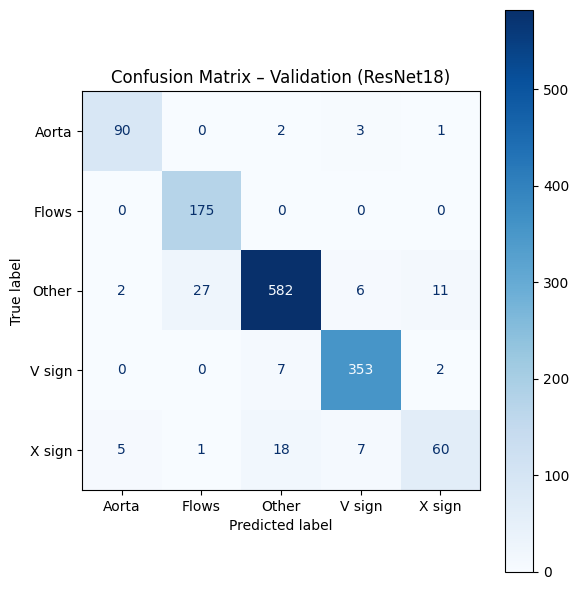


================ TEST RESULTS ================
              precision    recall  f1-score   support

       Aorta       0.75      0.76      0.76       133
       Flows       0.89      1.00      0.94       219
       Other       0.93      0.91      0.92       689
      V sign       0.90      0.93      0.91       259
      X sign       0.79      0.63      0.70        79

    accuracy                           0.89      1379
   macro avg       0.85      0.84      0.85      1379
weighted avg       0.89      0.89      0.89      1379

Confusion Matrix (Test):
[[101   4  25   0   3]
 [  0 219   0   0   0]
 [ 25  20 624  12   8]
 [  5   3   9 240   2]
 [  3   0  11  15  50]]


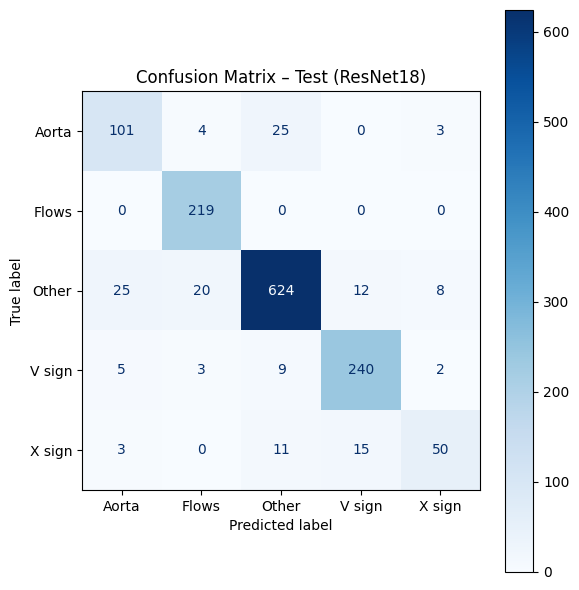

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# ================== LOAD BEST MODEL ==================
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

# ================== CONFUSION MATRIX PLOT ==================
def plot_cm(cm, title, class_names):
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=class_names
    )
    disp.plot(
        cmap=plt.cm.Blues,      # ✅ MÀU GỐC – MẶC ĐỊNH
        ax=ax,
        colorbar=True,
        values_format='d'
    )
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# ================== VALIDATION ==================
y_val_true, y_val_pred = [], []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_val_true.extend(labels.cpu().numpy())
        y_val_pred.extend(predicted.cpu().numpy())

print("\n================ VALIDATION RESULTS ================")
print(classification_report(y_val_true, y_val_pred, target_names=classes))

cm_val = confusion_matrix(y_val_true, y_val_pred)
print("Confusion Matrix (Validation):")
print(cm_val)

plot_cm(
    cm_val,
    "Confusion Matrix – Validation (ResNet18)",
    classes
)

# ================== TEST ==================
y_test_true, y_test_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_test_true.extend(labels.cpu().numpy())
        y_test_pred.extend(predicted.cpu().numpy())

print("\n================ TEST RESULTS ================")
print(classification_report(y_test_true, y_test_pred, target_names=classes))

cm_test = confusion_matrix(y_test_true, y_test_pred)
print("Confusion Matrix (Test):")
print(cm_test)

plot_cm(
    cm_test,
    "Confusion Matrix – Test (ResNet18)",
    classes
)
